# Testando os arquivos de OCR fornecidos pelo BID

## Importações

In [5]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt

## Código leitura arquivo OCR

In [4]:
encoding = 'ISO 8859-1'
example_ocr_file_path = '../../BID Dataset/RG_Verso/000111111_gt_ocr.txt'
example_image_path = '../../BID Dataset/RG_Verso/000111111_in.jpg'

In [3]:

def read_with_list(line: str):
    first_rbracket_index = line.find(']')
    second_rbracket_index = line.find(']', first_rbracket_index + 1)

    x = eval(line[:first_rbracket_index+1])
    y = eval(line[first_rbracket_index+3:second_rbracket_index+1])

    final_split = line[second_rbracket_index+3:].split(', ')

    width = int(final_split[0])
    height = int(final_split[1])
    transcription = final_split[2]

    return {
        'left': x,
        'top': y,
        'width': width,
        'height': height,
        'transcription': transcription
    }

def read_without_list(line):
    final_split = line.split(', ')
    
    return {
        'left': int(final_split[0]),
        'top': int(final_split[1]),
        'width': int(final_split[2]),
        'height': int(final_split[3]),
        'transcription': final_split[4]
    }

def read_ocr_file(file_path):
    with open(file_path, encoding=encoding) as ocr_file:
        rows = []
        ocr_file.readline()
        for line in ocr_file.readlines():
            line = line.strip()
            if line[0] == '[':
                rows.append(read_with_list(line))
            else:
                rows.append(read_without_list(line))
    return pd.DataFrame(rows)

ocr_df = read_ocr_file(example_file_path)
ocr_df

,left,top,width,height,transcription
0,"[50, 59, 41, 33]","[596, 229, 229, 597]",-1,-1,VÁLIDA EM TODO O TERRITÓRIO NACIONAL
1,74,519,18,138,08.096.661-5
2,141,261,20,479,REBELO RONEI NAKAMURAKARE
3,"[83, 86, 71, 73]","[749, 681, 682, 750]",-1,-1,REGISTRO
4,"[99, 100, 88, 87]","[749, 704, 704, 750]",-1,-1,GERAL
5,"[127, 129, 116, 115]","[749, 707, 706, 750]",-1,-1,NOME
6,"[196, 198, 183, 182]","[751, 688, 688, 751]",-1,-1,FILIAÇÃO
7,206,391,18,348,ADALTO CASCADAN FRASAO
8,240,283,20,455,JANDHER SALLES GASPERAZZO
9,"[305, 310, 297, 293]","[250, 94, 94, 252]",-1,-1,DATA DE NASCIMENTO


## Explicação sobre o formato do arquivo

Esse notebook visa entender os dois formatos de bounding boxes fornecidos pelos arquivos de ocr (pós-fixo "_gt_ocr.txt")

Todos os arquivos são parecidos com CSV's, tendo as seguintes colunas:

- **left**
- **top**
- **width**
- **height**
- **transcription**

Existem dois padrões de preencher esses dados, que serão explicados abaixo. A única coluna que se mantém o significado é a coluna de **transcription**, sendo o texto que deveria ser identificado.

### Primeiro padrão

O primeiro padrão é o seguinte:

- **left**: valor inteiro
- **top**: valor inteiro
- **width**: valor inteiro
- **height**: valor inteiro

Basicamente, o valor de **left** e **top** em conjunto especificam a coordenada do ponto superior esquerdo do texto. O **width** e o **height** especificam a largura e altura, respectivamente

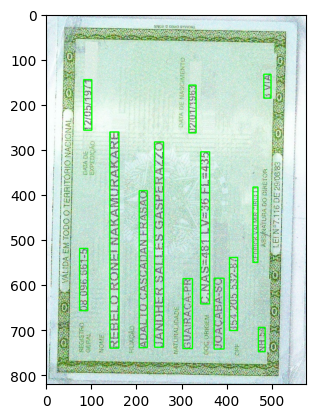

In [7]:
image = cv2.imread(example_image_path)

def draw_bounding_boxes_first_pattern(original_image, dataframe):
    for i, row in dataframe.iterrows():
        if row['width'] == -1:
            continue

        (x, y, w, h) = (row['left'], row['top'], row['width'], row['height'])
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

draw_bounding_boxes_first_pattern(image, ocr_df)
plt.imshow(image)
plt.show()

### Segundo padrão

O segundo padrão é o seguinte:

- **left**: vetor com quatro inteiros
- **top**: vetor com quatro inteiros
- **width**: -1
- **height**: -1

Nesse caso (aparentemente), o texto está um pouco inclinado, um retângulo reto não seria muito descritivo. Logo, são fornecidos 4 pontos, sendo **left[0]** e **top[0]** o primeiro ponto (canto superior esquerdo), e assim por diante

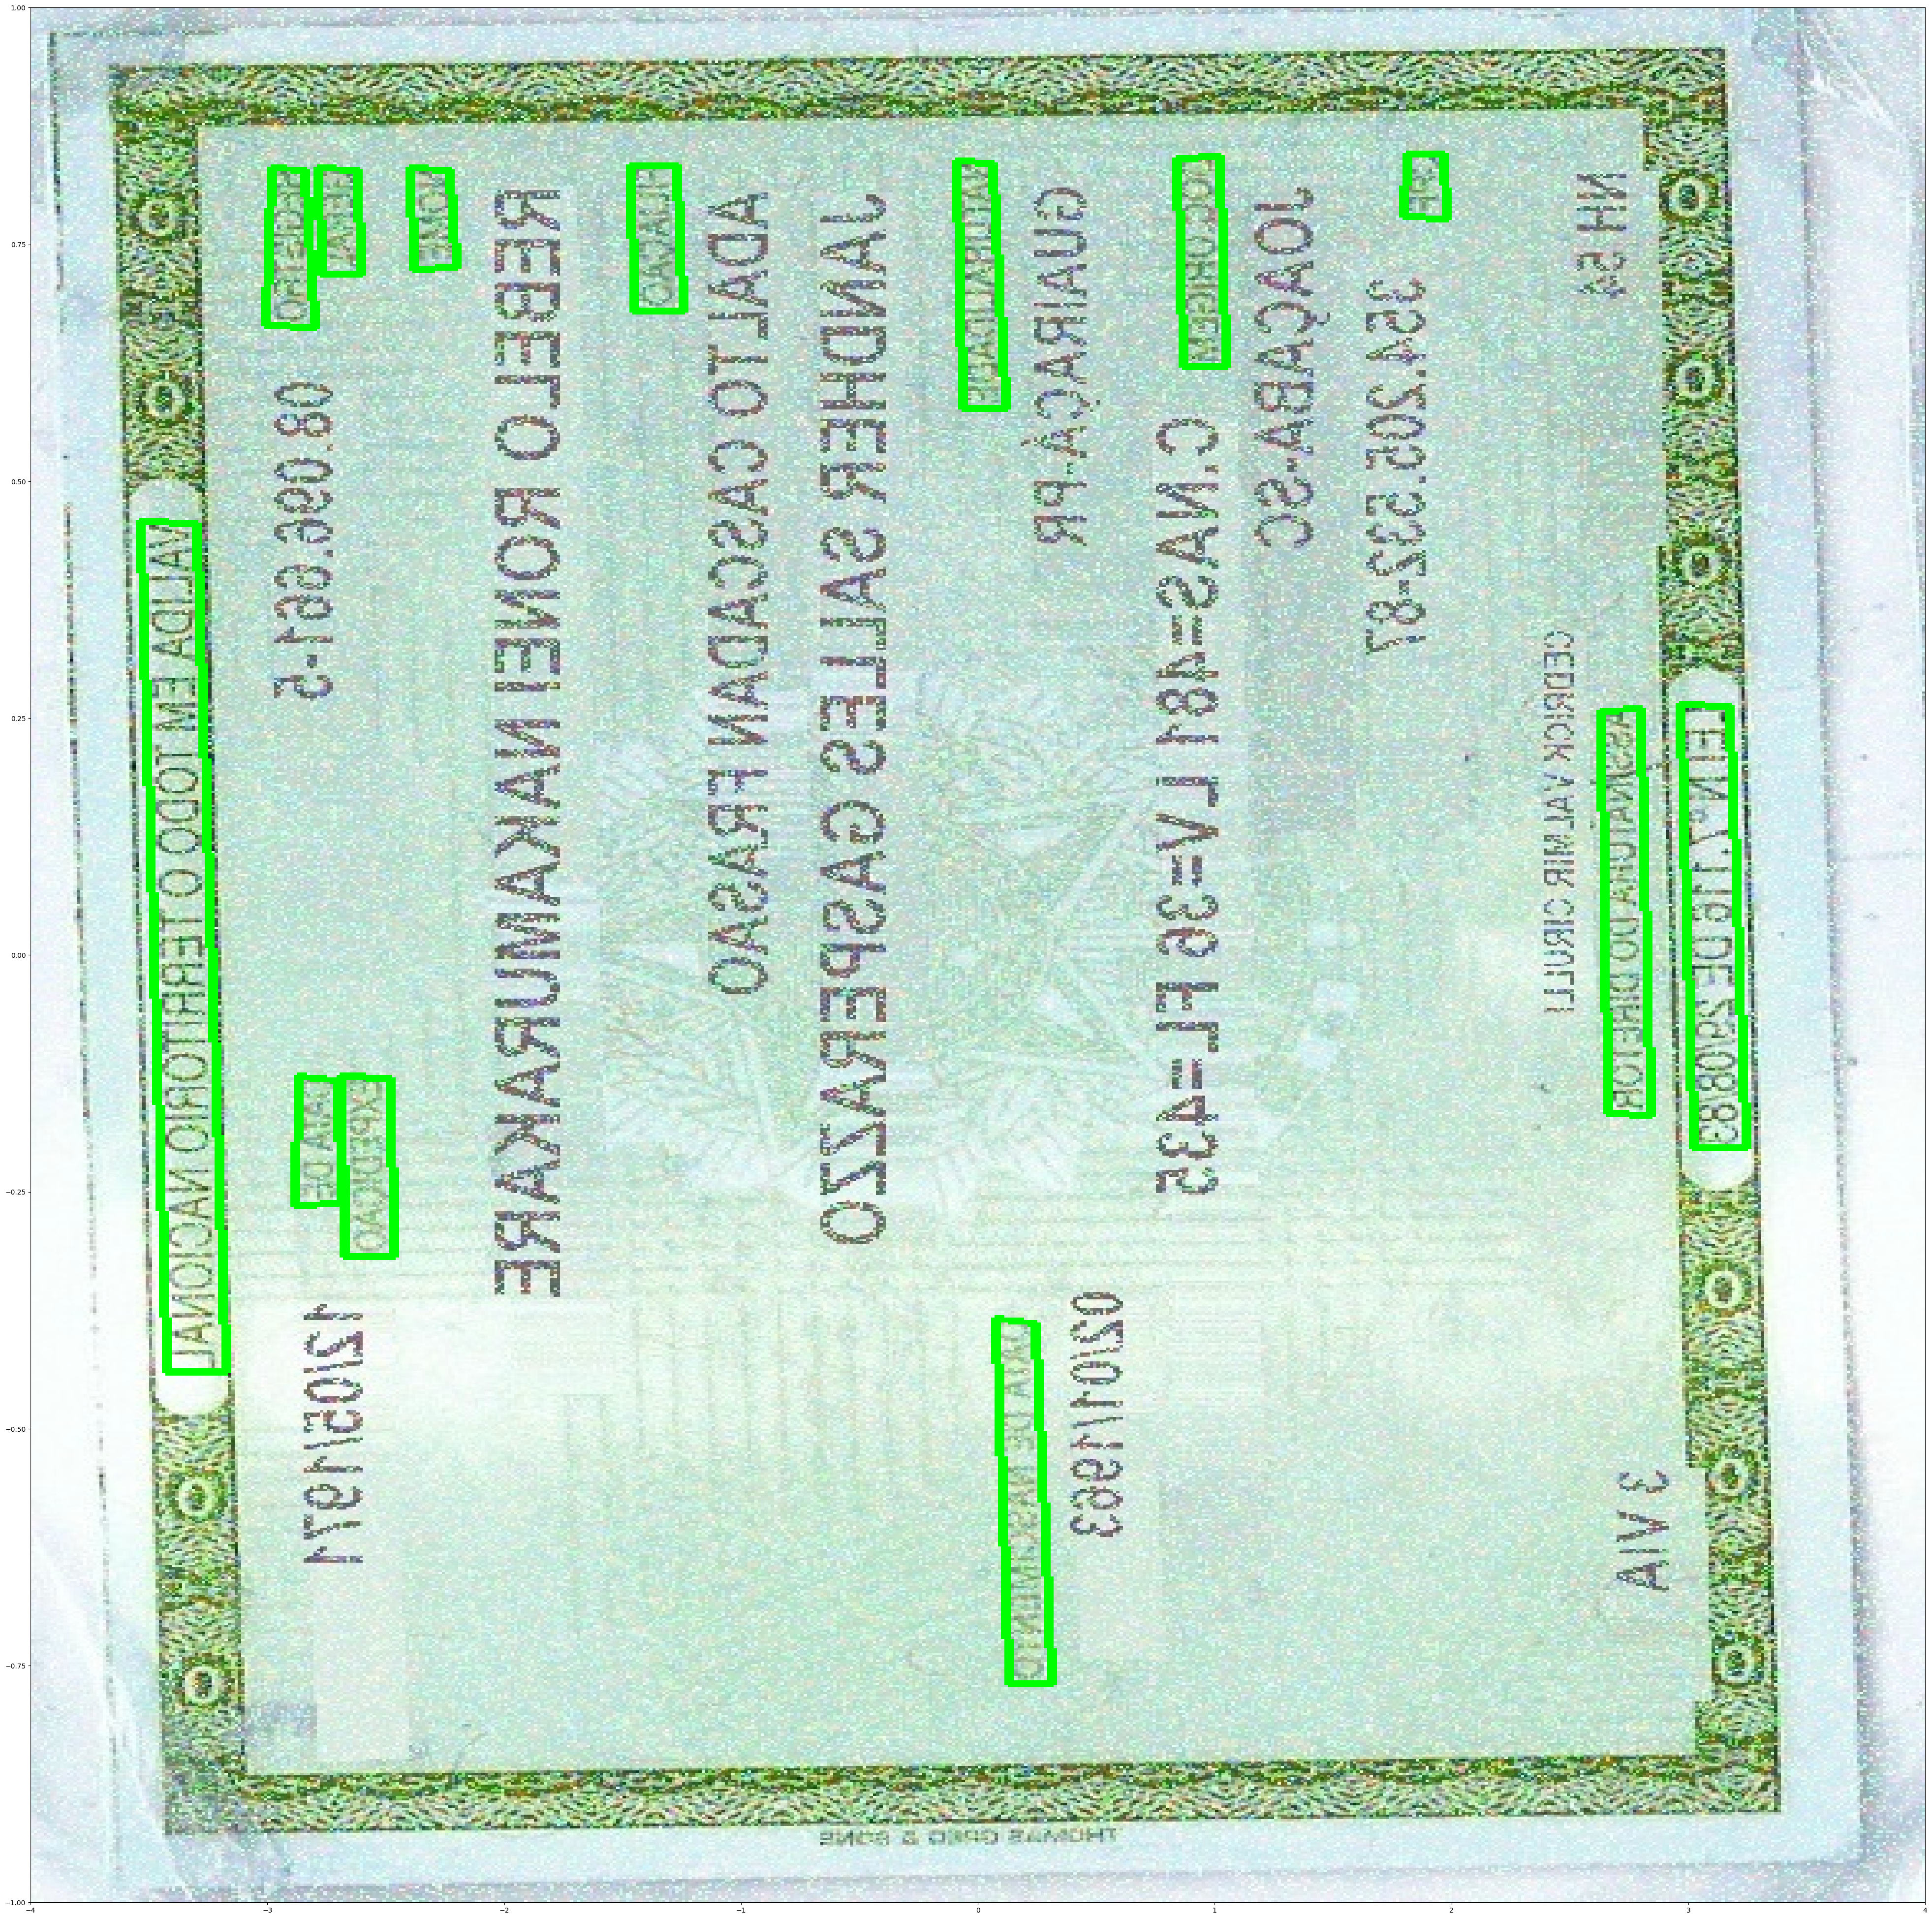

In [31]:
image = cv2.imread(example_image_path)

def draw_bounding_boxes_second_pattern(original_image, dataframe):
    for i, row in dataframe.iterrows():
        if row['width'] != -1:
            continue

        point1 = (row['left'][0], row['top'][0])
        point2 = (row['left'][1], row['top'][1])
        point3 = (row['left'][2], row['top'][2])
        point4 = (row['left'][3], row['top'][3])

        cv2.line(original_image, point1, point2, (0, 255, 0), 2)
        cv2.line(original_image, point2, point3, (0, 255, 0), 2)
        cv2.line(original_image, point3, point4, (0, 255, 0), 2)
        cv2.line(original_image, point4, point1, (0, 255, 0), 2)

draw_bounding_boxes_second_pattern(image, ocr_df)
plt.rcParams["figure.figsize"] = [100.0, 50.0]
plt.imshow(image, origin='lower', extent=[-4, 4, -1, 1], aspect=4)
plt.show()